# Activity recognition on the Capture24 dataset

## Long short-term memory

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

We have seen the importance of accounting for temporal dependencies in
the data to improve the classification performance. We have done so by using a
Hidden Markov Model to smooth the predictions of a random forest. Here we
look at using a more flexible model &mdash; the Long short-term memory (LSTM) &mdash;
to model the temporal dependencies to smooth the predictions of the random
forest.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm.auto import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

 ###### Grab a GPU if there is one 

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


 ###### Load dataset and hold out some instances for testing 

In [3]:
data = np.load('capture24.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
X, y, pid, time = data['X_feats'], data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
pids_test = [2, 3]  # participants 2 & 3
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (325619, 125)
Shape of X_test: (4991, 125)


 ###### Train random forest classifier 

In [4]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, verbose=True)
random_forest.fit(X_train, y_train)
# Grab out-of-bag probability estimations -- this will be the input to the LSTM
Y_train = random_forest.oob_decision_function_.astype('float32')
# This will be the test set inputs to the LSTM
Y_test = random_forest.predict_proba(X_test).astype('float32')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


## Smoothing the predictions with a LSTM
In the Hidden Markov Model, smoothing of the current prediction is based on
the current and past prediction of the random forest. Here we use a LSTM
to do the smoothing as a sequence-to-sequence prediction task: the neural
network takes a sequence of random forest predictions and outputs the
sequence of smoothed predictions.

###### Architecture design
Our baseline is a single-layer bidirectional LSTM.
The input to the network is a `(seq_length,N,5)` array corresponding to `N`
sequences of `seq_length` consecutive random forest probabilistic
predictions.
The output of the network is a `(seq_length,N,5)` array corresponding to
the smoothed predictions, represented as *unnormalized scores*.
To obtain probabilities, we can pass each row of the last axis to a softmax.
Then to report a class label, we can pick the highest probability in each
row. We output class scores instead of class probabilities or labels because
the loss function that we will use operates on the scores
[(torch.CrossEntropyLoss)](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

In [5]:
class LSTM(nn.Module):
    ''' Single-layer bidirectional LSTM '''
    def __init__(self, input_size=5, output_size=5, hidden_size=1024):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.hidden2output = nn.Linear(2*hidden_size, output_size)

    def forward(self, sequence):
        hiddens, (hidden_last, cell_last) = self.lstm(
            sequence.view(len(sequence), -1, self.input_size))
        output = self.hidden2output(
            hiddens.view(-1, hiddens.shape[-1])).view(
                hiddens.shape[0], hiddens.shape[1], self.output_size
        )
        return output

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training.
- A helper function that forward-passes the model on a dataset by chunks
&mdash; this is simply to prevent the memory from blowing up.
- A function that evaluates the model (RF + LSTM) on a dataset, to be used to
track the performance during training.

In [6]:
def create_dataloader(Y, y=None, seq_length=5, batch_size=1, shuffle=False, eval_mode=False):
    ''' Create a (batch) iterator over the dataset. It yields (batches of)
    sequences of consecutive rows of `Y` and `y` of length `seq_length` (can
    be less than `seq_length` in `eval_mode=True`). This iterator can also be
    implemented with PyTorch's Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if eval_mode:
        # In order to reuse this loader in evaluation/prediction mode, we
        # provide non-overlapping segments, as well as the trailing segments
        # that can be shorter than seq_length.
        n = len(Y)
        idxs = np.arange(0, n, seq_length)
    else:
        n = len(Y) - seq_length + 1
        idxs = np.arange(n)
    if shuffle:
        idxs = np.random.permutation(idxs)
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        # Separate those with irregular length -- these will be yielded one by one
        idxs_batch_regular = np.asarray(
            [j for j in idxs_batch if len(Y[j:j+seq_length]) == seq_length]
        )
        idxs_batch_irregular = np.asarray(
            [j for j in idxs_batch if j not in idxs_batch_regular]
        )
        # Yield batch of sequences of regular length (=seq_length)
        sequence_batch = np.stack([Y[j:j+seq_length] for j in idxs_batch_regular], axis=1)
        sequence_batch = torch.from_numpy(sequence_batch)
        if y is None:
            yield sequence_batch
        else:
            y_batch = np.stack([y[j:j+seq_length] for j in idxs_batch_regular], axis=1)
            y_batch = torch.from_numpy(y_batch)
            yield sequence_batch, y_batch
        # Yield sequences of irregular length uno por uno
        for j in idxs_batch_irregular:
            sequence_batch = torch.from_numpy(Y[j:j+seq_length]).unsqueeze(1)
            if y is None:
                yield sequence_batch
            else:
                y_batch = torch.from_numpy(y[j:j+seq_length]).unsqueeze(1)
                yield sequence_batch, y_batch


def forward_by_batches(lstm, Y_in, seq_length):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y_out = []
    lstm.eval()
    with torch.no_grad():
        for sequence in create_dataloader(
            Y_in, seq_length=seq_length, batch_size=1024, shuffle=False, eval_mode=True
        ):  # do not shuffle here!
            sequence = sequence.to(device)
            output = lstm(sequence)
            Y_out.append(output)
    lstm.train()
    # Concatenate sequences in order -- need to transpose to get batch-first format
    Y_out = torch.cat(
        [output.transpose(1,0).reshape(-1, output.shape[-1]) for output in Y_out]
    )
    return Y_out


def evaluate_model(random_forest, lstm, seq_length, Y, y, pid=None):
    Y_lstm = forward_by_batches(lstm, Y, seq_length)  # lstm smoothing (scores)
    loss = F.cross_entropy(Y_lstm, torch.from_numpy(y).to(device)).item()
    Y_lstm = F.softmax(Y_lstm, dim=-1)  # convert to probabilities
    y_lstm = torch.argmax(Y_lstm, dim=-1)  # convert to classes
    y_lstm = y_lstm.cpu().numpy()  # cast to numpy array
    scores = utils.compute_scores(y, y_lstm)
    return loss, scores

###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [7]:
hidden_size = 1024  # size of LSTM's hidden state
input_size = output_size = 5  # number of classes (sleep, sedentary, etc...)
seq_length = 5  # sequence length
num_epoch = 5  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

lstm = LSTM(
    input_size=input_size,
    output_size=output_size,
    hidden_size=hidden_size
).to(device)
print(lstm)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr, amsgrad=True)

LSTM(
  (lstm): LSTM(5, 1024, bidirectional=True)
  (hidden2output): Linear(in_features=2048, out_features=5, bias=True)
)


###### Training

Training via mini-batch gradient descent begins here. We loop through the
training set `num_epoch` times with the `dataloader` iterator.

In [8]:
accuracy_history = []
balanced_accuracy_history = []
kappa_history = []
loss_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(Y_train, y_train, seq_length, batch_size, shuffle=True)
    losses = []
    for sequence, target in dataloader:
        sequence, target = sequence.to(device), target.to(device)
        lstm.zero_grad()
        output = lstm(sequence)
        loss = loss_fn(output.view(-1,output.shape[-1]), target.view(-1))
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # -------------------------------------------------------------------------
    # Evaluate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on a large dataset.
    # -------------------------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Logging -- evaluate performance on test set
    loss_test, scores_test = evaluate_model(
        random_forest, lstm, seq_length, Y_test, y_test, pid_test)
    loss_history.append(loss_test)
    accuracy_history.append(scores_test['accuracy'])
    balanced_accuracy_history.append(scores_test['balanced_accuracy'])
    kappa_history.append(scores_test['kappa'])

 ###### Plot score and loss history 

Accuracy score: 0.8966139050290522
Balanced accuracy score: 0.6659592914840935
Cohen kappa score: 0.8360852251734472

Per-class recall scores:
sleep      : 0.9631742738589212
sedentary  : 0.9441692931112111
tasks-light: 0.0
walking    : 0.5709677419354838
moderate   : 0.8514851485148515

Confusion matrix:
 [[1857   69    0    2    0]
 [  72 2097    1   49    2]
 [   0  103    0   20    5]
 [   0   58   21  177   54]
 [   0   27   13   20  344]]


/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/cdthome/zhi722/.conda/envs/capture24/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


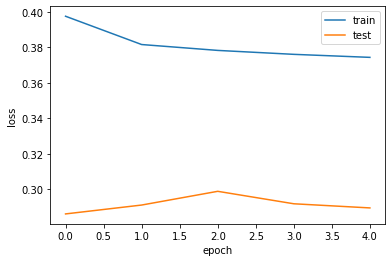

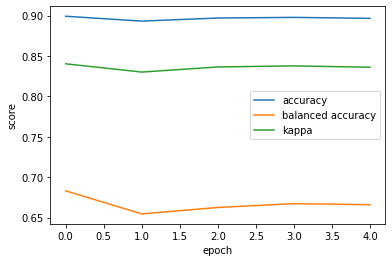

In [9]:
# Loss history
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

# Scores history
fig, ax = plt.subplots()
ax.plot(accuracy_history, label='accuracy')
ax.plot(balanced_accuracy_history, label='balanced accuracy')
ax.plot(kappa_history, label='kappa')
ax.set_ylabel('score')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

# Scores details -- last epoch
utils.print_scores(scores_test)

###### Ideas
- Implement early stopping to select the model at its best out-of-sample performance. Do we track kappa or accuracy?
- Tune size and number of layers of the LSTM. See [module doc](https://pytorch.org/docs/stable/nn.html#lstm).

###### References
- [Sequence models and LSTM in PyTorch](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)